In [2]:
%matplotlib inline
from __future__ import division
import numpy as np

import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import networkx as nx
from djPyi2 import mpltools
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import matplotlib.patches as patches
from djPyi2 import Common as CM
import matplotlib.image as mpimg

import numpy as np
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as mpatch
import matplotlib.transforms as mtransforms

In [3]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

In [4]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [5]:
dy_name = 'Figures'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

In [6]:
def fix_svlen(info_all):
    
    info_all = info_all.copy()
    info_all['SVLEN_MOD'] = info_all.SVLEN
    inds = info_all[info_all.SVTYPE_NR == 'STR'].index.tolist()
    info_all.loc[inds, 'SVLEN_MOD'] = info_all.loc[inds, 'MAX_ALLELE_CHANGE']
    info_all['log10_SVLEN_MOD'] = info_all['SVLEN_MOD'] 
    inds = info_all[(info_all.is_SVLEN == True) | (info_all.SVTYPE == 'INV')].index.tolist()
    info_all.loc[inds, 'log10_SVLEN_MOD'] = np.log10(info_all.loc[inds, 'SVLEN_MOD'].astype(float))
    return info_all

In [7]:
def get_rr_summary_sv(rr_all):
    rr_all['RR'] = rr_all['RR'].astype(float)
    rr_filt = rr_all[rr_all.id_col == 'Filtered']
    rr_unfilt = rr_all[~((rr_all.SVTYPE == 'STR') & (rr_all.id_col == 'Filtered'))]
    rr_filt['final_set']= rr_filt.final_set_per_caller
#     inds = rr_filt[rr_filt.SVTYPE== 'STR'].index.tolist()
#     rr_filt.loc[inds, 'final_set'] = True

    t1 = rr_filt[rr_filt.final_set].groupby(['SVTYPE_NR', 'CALLER']).RR.agg({'RR':'mean', 'stdev': 'std'})
    t1['stage'] = 'Filtered'
    t2 = rr_unfilt.groupby(['SVTYPE_NR', 'CALLER']).RR.agg({'RR':'mean', 'stdev': 'std'})
    t2['stage'] = 'Unfiltered'
    rr_summary = pd.concat([t1, t2]).reset_index()
    
#     t1 = rr_filt[rr_filt.final_set].groupby(['SVTYPE_NR', 'CALLER']).RR.std().to_frame('RR_std')
#     t1['stage'] = 'Filtered'
#     t2 = rr_unfilt.groupby(['SVTYPE_NR', 'CALLER']).RR.std().to_frame('RR_std')
#     t2['stage'] = 'Unfiltered'
#     rr_summary_std = pd.concat([t1, t2]).reset_index()
    
    return rr_summary, rr_filt, rr_unfilt

In [689]:
rr_summary, rr_filt, rr_unfilt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/rr_all_callers_twins.pkl').pipe(get_rr_summary_sv)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [8]:
info_pass_consented_472 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/info_pass_consented_annot_472.pkl')

In [9]:
intersect_lcnv_ss_gs = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_final_vcf/intersect_lcnv_ss_gs.pkl')

In [10]:
mappings = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/combine_mc_variant_info/mappings_ID_to_non_redun_all_final_update_lcnv.pkl')

d = mappings.Non_Redundant_ID.to_dict()
info_pass_consented_472['NR_ID2'] = info_pass_consented_472.ID.apply(lambda x: d.get(x,x))

nr_ids = info_pass_consented_472.NR_ID.unique().tolist()
svt = info_pass_consented_472.loc[nr_ids].SVTYPE_all.to_dict()
info_pass_consented_472['SVTYPE_NR2'] = info_pass_consented_472.NR_ID2.apply(lambda x: svt[x])

inds = info_pass_consented_472[info_pass_consented_472.CALLER == 'HipSTR'].index.tolist()
info_pass_consented_472.loc[inds, 'final_set_per_caller'] = True

info_pass_final = info_pass_consented_472[info_pass_consented_472.final_set_per_caller == True]
info_pass_final['CALLER']  = info_pass_final['CALLER'].apply(lambda x: {'LUMPY': 'SS'}.get(x, x))

In [13]:
info_pass_consented_472 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/info_unfilt_consented_472.pkl')
suff = info_pass_consented_472.ID.apply(lambda x: x.split('_')[-1])
info_pass_consented_472['suffix'] = suff
info_unfilt = info_pass_consented_472[~info_pass_consented_472.suffix.isin(['Stitched', 'Collapsed'])]
tdf = info_unfilt.groupby('CALLER').SVTYPE.value_counts().to_frame('Number of SV').reset_index()

In [28]:
CM.save_dataframe('number_of_vars_unfilt', tdf, private_out)

number_of_vars_unfilt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/number_of_vars_unfilt.pkl')
number_of_vars_unfilt = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/number_of_vars_unfilt.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/load_pickled_nb_variables.py


In [11]:
CM.save_dataframe('info_pass_final_nr_per_caller', info_pass_final, private_out)

info_pass_final_nr_per_caller = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/info_pass_final_nr_per_caller.pkl')
info_pass_final_nr_per_caller = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/info_pass_final_nr_per_caller.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/load_pickled_nb_variables.py


In [496]:
info_all['SVLEN_MOD'] = info_all.SVLEN
inds = info_all[info_all.SVTYPE_NR == 'STR'].index.tolist()
info_all.loc[inds, 'SVLEN_MOD'] = info_all.loc[inds, 'SVLEN_DS_RANGE']
info_all['log10_SVLEN_MOD'] = info_all['SVLEN_MOD'] 
inds = info_all[info_all.is_SVLEN == True].index.tolist()
info_all.loc[inds, 'log10_SVLEN_MOD'] = np.log10(info_all.loc[inds, 'SVLEN_MOD'].astype(float))

In [335]:
info_all_len = info_pass_final[info_pass_final.SVTYPE.isin(['DUP', 'DEL', 'rMEI', 
                                                                            'LINE1', 'SVA', 
                                                                            'ALU', 'mCNV', 'STR', 'INV'])]
info_all_len = info_all_len[(info_all_len.is_SVLEN) | (info_all_len.SVTYPE_all == 'INV')]
info_all_len = info_all_len.pipe(fix_svlen)

# evidence per site
evidence = info_pass_final.groupby("NR_ID").CALLER.apply(lambda x: ",".join(sorted(list(set(x)))))

info_nr = info_pass_consented_472[info_pass_consented_472.ID == info_pass_consented_472.NR_ID]
info_nr2 = info_pass_consented_472[info_pass_consented_472.ID == info_pass_consented_472.NR_ID2]
info_nr2 = info_nr2.pipe(fix_svlen)

evidence = info_pass_final.groupby("NR_ID").CALLER.apply(lambda x: ",".join(sorted(list(set(x)))))
info_nr['Site_Evidence'] = evidence

evidence = info_pass_final.groupby("NR_ID2").CALLER.apply(lambda x: ",".join(sorted(list(set(x)))))
info_nr2['Site_Evidence'] = evidence

info_nr_auto = info_nr2[~info_nr2.CHROM.isin(['X', 'Y'])]
info_nr_auto['Num_Evidence'] = info_nr_auto.Site_Evidence.apply(lambda x: len(x.split(',')))
info_nr_auto['MC'] = (info_nr_auto.Num_Evidence > 1).apply(lambda x: {True:'Multi-Caller', False: 'Single Caller'}[x])
d = info_all.NR_ID2.to_dict()
rr_filt['NR_ID2'] = rr_filt.ID.apply(lambda x: d.get(x,x))
rr_filt = rr_filt.merge(info_nr_auto[['NR_ID2','MC']], on = 'NR_ID2', how = 'left')

In [343]:
order_var = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'ALU', 'LINE1', 'SVA', 'STR']

order_vars_all = ['DEL', 'DUP', 'mCNV', 'INV', 'BND','rMEI', 'ALU', 'LINE1', 'SVA', 'STR', 'INDEL DEL', 
              'INDEL INS', 'SNV']

order_sv_str = order_vars_all[:-3]

In [359]:
def get_sb_evidence_types(info_nr):
    
    vc = info_nr.groupby('SVTYPE_all').Site_Evidence.value_counts().to_frame('No. Variants').reset_index()

    for_stacked_bar = pd.pivot_table(vc, index=['SVTYPE_all'], values = ['No. Variants'],
                                     columns = ['Site_Evidence'])
    for_stacked_bar.columns = for_stacked_bar.columns.droplevel()

    for_stacked_bar_frac = for_stacked_bar.copy()
    for_stacked_bar_frac['total'] = for_stacked_bar.sum(axis =1)
    for_stacked_bar_frac = for_stacked_bar_frac.fillna(0)

    cols_sb_var = 'GS	GS_LCNV GS,GS_LCNV	GS,GS_LCNV,SS	GS,SS 	SS 	HipSTR	MELT'.split()

    for c in cols_sb_var:
        for_stacked_bar_frac[c] = for_stacked_bar[c]/for_stacked_bar_frac['total']
    for_stacked_bar_frac = for_stacked_bar_frac.fillna(0)
    # total counts for side bar
    total_counts = vc.groupby('SVTYPE_all')['No. Variants'].sum().to_frame('Counts').loc[order_sv_str]
    total_counts['log_counts'] = np.log10(total_counts['Counts'])

    df_counts = vc.groupby(['SVTYPE_all', 'Site_Evidence'])['No. Variants'].sum().to_frame('Counts').reset_index()

    df_counts = df_counts[~df_counts['Site_Evidence'].isin(['MELT', 'HipSTR'])]

    convert_cats = {'GS':'100', 'GS,SS': '110', 'GS,GS_LCNV,SS': '111', 'GS_LCNV,SS': '011', 'SS':'010', 'GS_LCNV':'001', 'GS,GS_LCNV':'101'}
    df_counts['set_label'] = df_counts.Site_Evidence.apply(lambda x: convert_cats[x])
    set_all = df_counts.groupby('set_label').Counts.sum().to_dict()
    
    
    return for_stacked_bar, for_stacked_bar_frac, df_counts, set_all

In [360]:
sb_count, sb_frac, venn_count, set_count = get_sb_evidence_types(info_nr)

In [364]:
sb_count2, sb_frac2, venn_count2, set_count2 = get_sb_evidence_types(info_nr2)

In [385]:
svtypes = ['DEL', 'DUP', 'mCNV']
d_venns = []
for s in svtypes:
    tdf = venn_count2[venn_count2.SVTYPE_all == s]
    set_all = tdf.groupby('set_label').Counts.sum().to_dict()
    d_venns.append(set_all)

In [370]:
# intersect_lcnv_ss_gs_update = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_final_vcf/intersect_lcnv_ss_gs_update.pkl')

# Palettes

In [28]:
color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl').to_dict()

In [65]:
pallete_variant_callers = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/pallete_variant_callers.pkl').to_dict()

# Figure

In [53]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.3
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 2
mpl.gridspec.rcParams['axes.titlesize'] = 7
mpl.gridspec.rcParams['axes.labelsize'] = 7
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'

In [474]:
def draw_venns(ax, d, set_labels, fontsize = 8, alpha = 0.5, fontsize_outer = 9, lw = 1):
    v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels= set_labels, set_colors = color_sb, ax = ax, alpha = alpha)
    c = ['010', '011', '001', '111', '110', '100', '101']
    
    for i in c: 
        d[i] = d.get(i,0)
    
    for k in d.keys():
        p  = v.get_label_by_id(k)
        p.set_text(d[k])
        p.set_fontsize(fontsize)
    
    labs= ['A', 'B', 'C']
    for i, s in enumerate(set_labels):
        p  = v.get_label_by_id(labs[i])
        p.set_fontsize(fontsize_outer)

    c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='-', ax = ax, linewidth= lw)
    return v, c

In [726]:
order_callers = [['GS', 'GS_LCNV', 'SS'], ['GS', 'GS_LCNV', 'SS'], ['GS', 'GS_LCNV'], 
                 ['SS'], ['MELT'], ['MELT'], ['MELT'], ['HipSTR']]
order_cnvs = ['DEL','DUP', 'mCNV']
order_vc_leg = ['SS', 'GS', 'GS_LCNV', 'MELT', 'HipSTR']

In [70]:
order_sv_str = order_vars[:-3]
order_sv_str_len = [i for i in order_sv_str if i != 'BND']

In [ ]:
labels_legend_vars_all = ['DEL', 'DUP', 'mCNV']
order_vars_all_leg = ['DEL', 'DUP', 'mCNV']
colors_legend = [color_pal_svtypes_all.get(i, 'white') for i in order_vars_all_leg]
rect_lws_legend =  [0.1 if i in order_vars_all else 0 for i in order_vars_all_leg]

patches = mpltools.get_legend_patches(labels_legend_vars_all, just_rect=True, 
                                      rectfacecolor=colors_legend, rectedgecolor='black', 
                                      rectlinewidth=rect_lws_legend)
leg = leg_ax.legend(handles = patches, bbox_to_anchor = [bbox_coord_left,loc_y],
                      loc = 'upper left', frameon= True, ncol=1,
                      fontsize=fontsize, title = 'CNVs')

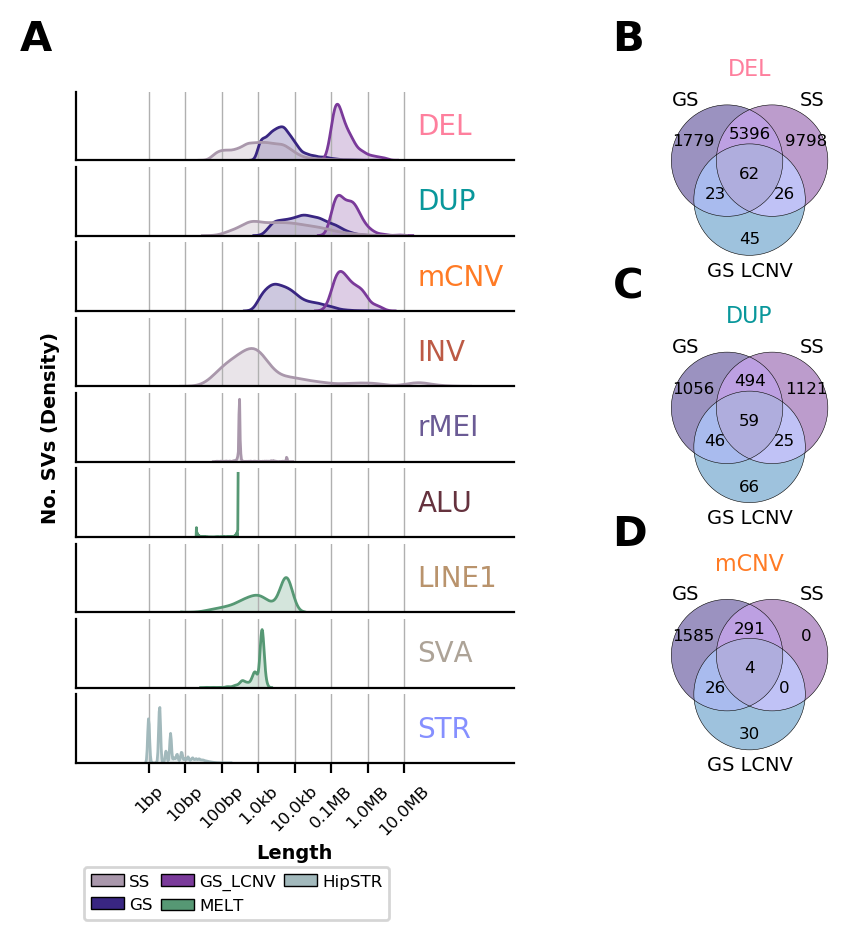

In [711]:
fig =plt.figure(figsize=(7,7), dpi = 200)
# fig, axes = plt.subplots(4,4, figsize = (7,7), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5})
gs = mpl.gridspec.GridSpec(2, 2, 
                           figure =fig,
                           width_ratios=[0.8, 1], height_ratios = [1, 0.5], wspace = 0.2, hspace=0.1)



subgrid_bb = mpl.gridspec.GridSpecFromSubplotSpec(9,1, subplot_spec= gs[0,0], wspace=0.3,
                                               hspace= 0.1, width_ratios = [1])

order_callers = [['GS', 'GS_LCNV', 'SS'], ['GS', 'GS_LCNV', 'SS'], ['GS', 'GS_LCNV'], 
                 ['SS'], ['SS'], ['MELT'], ['MELT'], ['MELT'], ['HipSTR']]

axes = []
for i, svt in enumerate(order_sv_str_len):
    if i == 0:
        a = fig.add_subplot(subgrid_bb[i: i+1, 0], facecolor = (0,0,0,0))
    else:
        a = fig.add_subplot(subgrid_bb[i: i+1, 0], facecolor = (0,0,0,0), sharex = a)
    for c in order_callers[i]:
        tdf = info_all_len[(info_all_len.SVTYPE_all == svt) & (info_all_len.CALLER == c)]
        c =  sns.kdeplot(tdf['log10_SVLEN_MOD'],ax = a, color = pallete_variant_callers[c],
                        label = c, legend = False, shade = True, lw = 1)
        
    y = np.mean(a.get_ylim())
    sns.despine(ax =a, left = False)
    a.set_yticklabels([])
    a.tick_params(axis = 'y', length = 0)
    a.xaxis.grid(linewidth = 0.5)
    if svt != 'STR':
        a.tick_params(axis = 'x', length = 0)
        plt.setp(a.get_xticklabels(), visible=False)
        
    a.text(0.78, 0.5, svt, color= color_pal_svtypes_all[svt], clip_on = False, transform = a.transAxes,
          horizontalalignment='left',  verticalalignment='center')
    axes.append(a)
    
xlab = [10**i for i in np.arange(0,8)]
xticks = [np.log10(i) for i in xlab]
xlab_fmt = mpltools.format_base_pair_scale(xlab, mb_round=1)

a.set_xticks(xticks)
a.set_xticklabels(xlab_fmt)
a.tick_params(axis = 'x', labelrotation = 45)
a.set_xlabel('Length')
axes[4].set_ylabel('No. SVs (Density)')

ax = axes[-1]
colors_legend = [pallete_variant_callers.get(i, 'white') for i in order_vc_leg]
patches = mpltools.get_legend_patches(order_vc_leg, just_rect=True, 
                                          rectfacecolor=colors_legend, rectedgecolor='black', 
                                          rectlinewidth= 0.5)

ax.legend(handles = patches, bbox_to_anchor = [0,-1.4],
                          loc = 'upper left', frameon= True, ncol=3,
                          fontsize=6)


# order_intersect_callers = 'GS	GS_LCNV GS,GS_LCNV	GS,GS_LCNV,SS	GS,SS GS_LCNV,SS	SS 	HipSTR	MELT'.split()
# color_sb = [pallete_variant_callers[i] for i in order_intersect_callers]
# for_stacked_bar_frac.loc[reversed(order_sv_str)][cols].plot(kind= 'barh', 
#                                                             stacked = True, color = color, ax = ax2)
subgrid_sb = mpl.gridspec.GridSpecFromSubplotSpec(3,2, subplot_spec= gs[0,1], wspace= 0,
                                               hspace= 0.4, width_ratios = [1,1])

ax2 = fig.add_subplot(subgrid_sb[0,0])
ax3 = fig.add_subplot(subgrid_sb[1,0])
ax4 = fig.add_subplot(subgrid_sb[2,0])

sl = ['GS', 'SS', 'GS LCNV']
axes_2 = [ax2, ax3, ax4]
for i, svt in enumerate(order_cnvs):
    a = axes_2[i]
    v, c = draw_venns(a, d_venns[i], sl, fontsize_outer=7, fontsize=6, lw = 0.2)
    a.set_title(svt, color = color_pal_svtypes_all[svt], fontsize = 8)
    
    
# ax5 = fig.add_subplot(subgrid_sb[0,1])
# ax6 = fig.add_subplot(subgrid_sb[1,1])
# ax7 = fig.add_subplot(subgrid_sb[2,1])

labels = ['A']
for i, a in enumerate([axes[0]]):
    mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 15)
    
labels = ['B', 'C', 'D']
for i, a in enumerate([ax2, ax3,ax4]):
    mpltools.label_offset_axes(a, fig, labels[i], x = 0, y = 15)
    
    
# ax5 = fig.add_subplot(gs[1,0])
# ax5  = sns.barplot(x = 'SVTYPE_NR', y = 'RR', hue = 'MC', data = rr_nr_plot, 
#                 ax = ax5, palette=color_pal_mc)


fig.savefig(os.path.join(private_out, 'SupFig_Length_and_Intersection_of_Callers'), dpi=500, bbox_inches='tight') 

